# Modules Import 

In [23]:
!pip install torchmetrics
# !sudo apt update
! sudo apt install sox libsox-fmt-all
!pip install sox

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsox-fmt-all is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [24]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import math
import sox
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Dataset Pre-processing

In [25]:
"""def extract_MFCC(file_path,n_mfcc=40,max_pad_length=174): # librosa used
    # signal: Numpy array of amplitude values
    # sr : sampling rate...2250 implies we take discere 2250 numerical values from analog signal of 1s audio to approximate digitally
    signal, sr = librosa.load(file_path,sr=2250)
    
    # n_mfcc : no of mfcc coefficients:
    #This means that for each short segment of the audio, 
    #the function will generate a vector of 40 numbers that represents its spectral characteristics.
    #mfcc == features of an image in CV
    if augment:
        mod=augmentation(sr=2250,noise=.05)
        signal=mod(signal)
    mfcc=librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    # padding and truncating
    # .shape[1] ---> the no of cols/time frame/vectors in above discussion
    # if less than target shape, pad with zero else truncate
    if mfcc.shape[1]<max_pad_length:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:max_pad_length]
    return mfcc"""


"def extract_MFCC(file_path,n_mfcc=40,max_pad_length=174): # librosa used\n    # signal: Numpy array of amplitude values\n    # sr : sampling rate...2250 implies we take discere 2250 numerical values from analog signal of 1s audio to approximate digitally\n    signal, sr = librosa.load(file_path,sr=2250)\n    \n    # n_mfcc : no of mfcc coefficients:\n    #This means that for each short segment of the audio, \n    #the function will generate a vector of 40 numbers that represents its spectral characteristics.\n    #mfcc == features of an image in CV\n    if augment:\n        mod=augmentation(sr=2250,noise=.05)\n        signal=mod(signal)\n    mfcc=librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)\n\n    # padding and truncating\n    # .shape[1] ---> the no of cols/time frame/vectors in above discussion\n    # if less than target shape, pad with zero else truncate\n    if mfcc.shape[1]<max_pad_length:\n        pad_width = max_pad_len - mfcc.shape[1]\n        mfcc = np.pad(mfcc, pad_w

In [26]:
# # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
# Emotion_labels={
#     '01':'neutral',
#     '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry',
#     '06' : 'fearful', '07': 'disgust', '08' :  'surprised'
# }

# # Audio Augementation
# class augmentation(nn.Module):
#     def __init__(self,sr=22050,noise=.01):
#         super().__init__()
#         self.vol = T.Vol(gain=random.uniform(0.8, 1.2))
#         self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
#         self.time_mask = T.TimeMasking(time_mask_param=35)
#         self.noise_level = noise

#     def forward(self, waveform):
#          # Randomly gains / supresses dB , mimicking human conversation.
#         waveform = self.vol(waveform)
#          # maximum possible length of the mask. Indices uniformly sampled from [0, freq_mask_param). Allowing th model to predict not pn fixed band only.
#          # Randomly masks out parts of the frequency range. Makes the model rely on multiple cues, not just a fixed band.
#         waveform = self.freq_mask(waveform)
#          # maximum possible length of the mask. Indices uniformly sampled from [0, time_mask_param). Allowing th model to predict not on fixed band only.
#          # Randomly masks out segments of time. Improves generalization over varying speech speed or silence.
#         waveform = self.time_mask(waveform)
        
#         noise = self.noise_level * torch.randn_like(waveform)
#         return waveform + noise
            
# # Get emotion data only.
# def get_emotion(filename):
#     temp=filename.split('-')
#     emotion_code=temp[2]
#     emotion_label=Emotion_labels[emotion_code]
#     return emotion_label

# # Extract the MEL 
# def extract_mel_features(file_path, n_mels=40, max_pad_len=174, augment=False): #pure Pytorch
#     waveform, sr = torchaudio.load(file_path)
#     mod=augmentation(sr=22050,noise=.05)
#     # stereo to mono
#     if waveform.shape[0]>1: # indicates stereo if true
#         waveform=waveform.mean(dim=0,keepdim=True) # converted to mono for eliminating ambiguity !
#     # Sample Rate consistency
#     if sr != 22050:
#         resampler = T.Resample(sr, 22050)
#         waveform = resampler(waveform)
#         sr = 22050
#     # Augment
#     if augment:
#         waveform=mod(waveform)
#     # mel_spectogram
#     mel_transform = T.MelSpectrogram(
#         sample_rate=sr,
#         n_mels=n_mels,
#     # hop length= stride for temporal feature gain.
#     # n_fft=samples used in fourier transforms--->2048/22050 , almost every 93ms
#         n_fft=2048,
#         hop_length=512
#     )
#     mel_spec = mel_transform(waveform)  # shape: [1, n_mels, time]
#     mel_spec = mel_spec.squeeze(0)  # shape: [n_mels, time]

#     # Convert to log-MEL (better for emotion detection)
#     mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10, amin=1e-10, db_multiplier=0)

#     # Padding/Truncation 
#     if mel_spec.shape[1] < max_pad_len:
#         pad_width = max_pad_len - mel_spec.shape[1]
#         mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_width))
#     else:
#         mel_spec = mel_spec[:, :max_pad_len]
    
#     # Normalize (per-channel):  
#     # It keeps frequency-specific patterns and removes energy bias. Instead of global stats norm , since it may erase,
#     # certain fre contrast aggressively, very sensetive for voice.
#     mel_spec = (mel_spec - mel_spec.mean(dim=1, keepdim=True)) / (mel_spec.std(dim=1, keepdim=True) + 1e-6)
    
#     return mel_spec

In [27]:
# Emotion labels
Emotion_labels = {
    '01': 'neutral',
    '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry',
    '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Audio Augmentation Class
class augmentation(nn.Module):
    def __init__(self, sr=22050, noise=0.01):
        super().__init__()
        self.sr = sr
        self.noise_level = noise
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
        self.time_mask = T.TimeMasking(time_mask_param=35)

    def pitch_shift(self, waveform):
        n_steps = random.randint(-2, 2)
        effects = [
            ["pitch", str(n_steps * 100)],
            ["rate", str(self.sr)]
        ]
        shifted_waveform, _ = sox.apply_effects_tensor(waveform, self.sr, effects)
        return shifted_waveform
    
    def random_crop_pad(self, waveform, target_len=22050):
        current_len = waveform.size(1)
        if current_len < target_len:
            pad_left = random.randint(0, target_len - current_len)
            pad_right = target_len - current_len - pad_left
            waveform = torch.nn.functional.pad(waveform, (pad_left, pad_right))
        else:
            start = random.randint(0, current_len - target_len)
            waveform = waveform[:, start:start + target_len]
        return waveform

    def forward(self, waveform):
        # Random gain (volume) - created fresh every call
        gain_val = random.uniform(0.7, 1.3)
        vol = T.Vol(gain=gain_val)
        waveform = vol(waveform)

        # Frequency and time masking
        waveform = self.freq_mask(waveform)
        waveform = self.time_mask(waveform)

        # Add noise
        noise = self.noise_level * torch.randn_like(waveform)
        waveform = waveform + noise

        # Random pitch shift (50% chance)
        if random.random() < 0.5:
            waveform = self.pitch_shift(waveform)

        # Random polarity inversion (50% chance)
        if random.random() < 0.5:
            waveform = -waveform

        # Optional: Random speed perturbation (uncomment if desired)
        # if random.random() < 0.5:
        #     speed = random.uniform(0.9, 1.1)
        #     effects = [["speed", str(speed)], ["rate", str(self.sr)]]
        #     waveform, _ = sox.apply_effects_tensor(waveform, self.sr, effects)

        # Crop or pad to fixed length
        waveform = self.random_crop_pad(waveform, target_len=self.sr)

        return waveform

# Get emotion label from filename
def get_emotion(filename):
    temp = filename.split('-')
    emotion_code = temp[2]
    emotion_label = Emotion_labels[emotion_code]
    return emotion_label

# Extract mel spectrogram with optional augmentation module reuse
def extract_mel_features(file_path, n_mels=40, max_pad_len=174, augment=False, augment_module=None):
    waveform, sr = torchaudio.load(file_path)
    
    # Convert stereo to mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Resample to 22050 Hz if needed
    if sr != 22050:
        resampler = T.Resample(sr, 22050)
        waveform = resampler(waveform)
        sr = 22050

    # Apply augmentation if requested
    if augment and augment_module is not None:
        waveform = augment_module(waveform)
    
    # Mel spectrogram transform
    mel_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_mels=n_mels,
        n_fft=2048,
        hop_length=512,
    )
    mel_spec = mel_transform(waveform)  # shape: [1, n_mels, time]
    mel_spec = mel_spec.squeeze(0)      # shape: [n_mels, time]

    # Convert to log-MEL
    mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10, amin=1e-10, db_multiplier=0)

    # Pad or truncate to max_pad_len
    if mel_spec.shape[1] < max_pad_len:
        pad_width = max_pad_len - mel_spec.shape[1]
        mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_width))
    else:
        mel_spec = mel_spec[:, :max_pad_len]

    # Per-channel normalization (mean/std per mel bin)
    mel_spec = (mel_spec - mel_spec.mean(dim=1, keepdim=True)) / (mel_spec.std(dim=1, keepdim=True) + 1e-6)

    return mel_spec


*Creating Dataloader*

In [28]:
def load_data(data_dir):
    file_paths = []
    labels = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                if os.path.exists(file_path):  # Add existence check
                    try:
                        labels.append(get_emotion(file))
                        file_paths.append(file_path)
                    except Exception as e:
                        print(f"Skipping {file}: {str(e)}")
    return file_paths, labels

class ED(Dataset):
    def __init__(self, file_paths, labels, augment=False):
            self.file_paths = file_paths
            self.labels = torch.tensor(labels, dtype=torch.long)
            self.augment = augment
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mel = extract_mel_features(self.file_paths[idx], augment=self.augment)
        return mel.unsqueeze(0), self.labels[idx]


In [29]:
data_dir = "/kaggle/input/ravdess-emotional-speech-audio"
file_paths, text_labels = load_data(data_dir)  # Assuming this returns text labels like 'neutral', 'happy' etc.

# 2. Create explicit label mapping (more maintainable)
emotion_to_idx = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

# 3. Convert to numerical labels
labels_encoded = np.array([emotion_to_idx[label] for label in text_labels])

# Train: 70% , val: 15% , test: 15%
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(file_paths, labels_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=labels_encoded)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(X_temp_paths, y_temp, test_size=0.2, random_state=42, shuffle=True, stratify=y_temp)

train_dataset = ED(X_train_paths, y_train, augment=True) # True
val_dataset = ED(X_val_paths, y_val, augment=False)
test_dataset = ED(X_test_paths, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

*Batch Dimension check*

In [30]:
temp=0
for batch_audio, batch_labels in train_loader:
    print("Train batch shape:", batch_audio.shape)
    print("Train labels:", batch_labels.shape)
    temp=batch_audio[0]
    break
for batch_audio, batch_labels in test_loader:
    print("Val batch shape:", batch_audio.shape)
    print("Val labels:", batch_labels.shape)
    print(batch_labels[1])
    break
for batch_audio, batch_labels in val_loader:
    print("Test batch shape:", batch_audio.shape)
    print("Test labels:", batch_labels.shape)
    break

# 40 ----> Spectral coefficent Vector of 40  numbers
# 174 ----> max no of cols / time frames of spectral vectors

Train batch shape: torch.Size([32, 1, 40, 174])
Train labels: torch.Size([32])
Val batch shape: torch.Size([32, 1, 40, 174])
Val labels: torch.Size([32])
tensor(6)
Test batch shape: torch.Size([32, 1, 40, 174])
Test labels: torch.Size([32])


*MEL spectogram Plot*

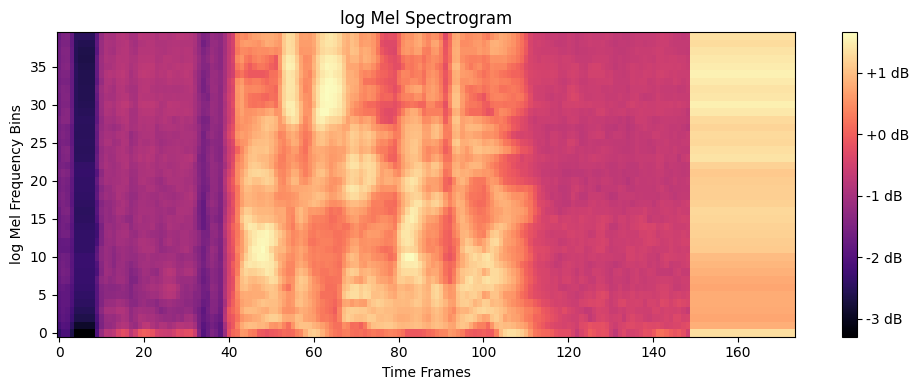

In [31]:
# Example tensor: shape [1, n_mels, time_steps]
mel_tensor = temp  # shape: [1, 40, 174]

# Step 1: Convert from PyTorch tensor to NumPy
mel_np = mel_tensor.squeeze(0).numpy()  # shape: [40, 174]

# Step 2: Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_np, aspect='auto', origin='lower', cmap='magma')  # or 'viridis', 'inferno'
plt.colorbar(format='%+2.0f dB')
plt.title('log Mel Spectrogram')
plt.ylabel('log Mel Frequency Bins')
plt.xlabel('Time Frames')
plt.tight_layout()
plt.show()


# Model Build : ( Hybrid ) ---> CNN + Transformer

In [32]:
# In the paper, positional encodings are done by incorporating sinusoids , to learn relative positions of two letters/words, keeping it unique too ! 
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

***Model class***

In [36]:
# class ACNT(nn.Module):
#     def __init__(self,num_classes=8,in_channel=1,max_time_frame=174,cnn_out_channel=128,num_heads=8,transformer_dim=128,num_layers=2):
#         super(ACNT,self).__init__()
#         # CNN architecture to eliminate redundant information and lower dim
#         self.cnn= nn.Sequential(
#             nn.Conv2d(in_channel,16,kernel_size=3 , padding=1),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(.1),                                 
#             nn.MaxPool2d(2),                            # B*16*20*87

#             nn.Conv2d(16,64,kernel_size=3 , padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(.1),                                 
#             nn.MaxPool2d(2),                             # B*64*10*43

#             nn.Conv2d(64,128,kernel_size=3 , padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),                                 
#             nn.MaxPool2d(2),                              # B*128*5*21
#         )

# # Sequential module is not a list , it's a tuple !!!
#         # LAYER BEFORE TRANSFORMER
#         self.flatten=nn.Sequential(
#             nn.Conv2d(128,transformer_dim,kernel_size=3,padding=1),                       
#             nn.ReLU()                                   # B*128*10*43
#         )

#         # Positional Encoding Layer
#         self.PE=PositionalEncoding(d_model=transformer_dim)

#         # Transformer Encoder Layer 
#         self.encoder_layer=nn.TransformerEncoderLayer(d_model=transformer_dim,nhead=8,dropout=.2,activation="gelu",batch_first=True)
        
#         # Encoder only Transformer [ for temporal attention ].
#         self.transformer=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
        
#         # Classification Head
#         self.neural_net=nn.Sequential(
#             nn.Linear(transformer_dim,transformer_dim//2),
#             nn.LeakyReLU(.1),
#             nn.Dropout(.1),
#             nn.Linear(transformer_dim//2,num_classes)
#         )

#         #Projection of 1280--->128
#         self.proj=nn.Linear(transformer_dim*10,transformer_dim)
        
#     def forward(self,x):   # x----> [B,1,40,174]
        
#         features_cnn=self.cnn(x) # features_cnn ----> [B,64,10,43]
#         features_cnn_proj=self.flatten(features_cnn) # features_cnn_proj------> [B,128,10,43]
        
#         # Since batch_first==True, we need to provide the tensor as [B, sequence, data] dim
#         B,C,H,W= features_cnn_proj.shape
#         features_cnn_proj=features_cnn_proj.permute(0,3,1,2) # [B,43,128,10]
#         features_cnn_proj=features_cnn_proj.flatten(2) # [B,43,1280]
#         features_cnn_proj=self.proj(features_cnn_proj) # Projecting 1280--->128 to match transformer input

#         # positional encoding for sequence maintain
#         features_cnn_proj=self.PE(features_cnn_proj) 

#         # Parsing through Transformer
#         transformer_output=self.transformer(features_cnn_proj) # [B,43,128]

#         # Perform Global average Pooling over time frames
#         transformer_output=transformer_output.mean(dim=1)

#         # Parse through classifier Head finally
#         classifier_output_raw=self.neural_net(transformer_output)
#         return classifier_output_raw

class ACNT(nn.Module):
    def __init__(self, 
                 num_classes=8,
                 in_channel=1,
                 input_shape=(40, 174),
                 cnn_channels=[16, 32, 64, 128],
                 transformer_dim=128,
                 num_heads=8,
                 num_layers=4,
                 pe_max_len=5000,
                 dropout_rate=0.1,
                 use_transformer=True):
        super(ACNT, self).__init__()
        self.use_transformer = use_transformer
        self.cnn_channels = cnn_channels
        
        # CNN architecture with proper residual connections
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channel, cnn_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[0]),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2),  # B × 16 × 20 × 87
            
            # Block 2
            nn.Conv2d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[1]),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2),  # B × 32 × 10 × 43
            
            # Block 3 with residual
            ResidualBlock(
                nn.Sequential(
                    nn.Conv2d(cnn_channels[1], cnn_channels[2], kernel_size=3, padding=1),
                    nn.BatchNorm2d(cnn_channels[2]),
                    nn.LeakyReLU(0.1),
                    nn.Dropout2d(dropout_rate)
                )
            ),
            nn.MaxPool2d(2),  # B × 64 × 5 × 21
            
            # Block 4 with residual
            ResidualBlock(
                nn.Sequential(
                    nn.Conv2d(cnn_channels[2], cnn_channels[3], kernel_size=3, padding=1),
                    nn.BatchNorm2d(cnn_channels[3]),
                    nn.ReLU(),
                    nn.Dropout2d(dropout_rate)
                )
            )  # B × 128 × 5 × 21
        )
        
        # Calculate flattened dimension after CNN
        self.H_after_cnn = input_shape[0] // (2 ** 3)  # 3 pooling layers
        self.W_after_cnn = input_shape[1] // (2 ** 3)
        self.flattened_dim = cnn_channels[-1] * self.H_after_cnn

        # Projection layer
        self.proj = nn.Sequential(
            nn.Linear(self.flattened_dim, transformer_dim),
            nn.LayerNorm(transformer_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )

        # Transformer components
        if self.use_transformer:
            self.PE = PositionalEncoding(transformer_dim, pe_max_len)
            self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=transformer_dim,
                nhead=num_heads,
                dropout=dropout_rate,
                activation="gelu",
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)

        # Classification head
        self.head = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            nn.Linear(transformer_dim//2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        
        # CNN forward
        x = self.cnn(x)  # B × C × H × W
        B, C, H, W = x.shape
        # Prepare for transformer
        x = x.permute(0, 3, 2, 1)  # B × W × H × C
        x = x.reshape(B, W, H * C)  # Explicit dimensions  # B × W × (H*C)
        x = self.proj(x)  # B × W × D

        # Transformer
        if self.use_transformer:
            x = self.PE(x)
            x = self.transformer(x)
            x = x.mean(dim=1)  # Mean pooling over time
        else:
            x = x.mean(dim=1)

        # Classification
        return self.head(x)

class ResidualBlock(nn.Module):
    def __init__(self, sublayer):
        super(ResidualBlock, self).__init__()
        self.sublayer = sublayer
        
    def forward(self, x):
        residual = x
        x = self.sublayer(x)
        # Only add residual if dimensions match
        if x.shape == residual.shape:
            return x + residual
        return x


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate the improved model
model = ACNT(
    num_classes=8,
    in_channel=1,
    input_shape=(40, 174),
    cnn_channels=[16, 32, 64, 128],  # More balanced channel progression
    transformer_dim=128,              # Reduced dimension for better efficiency
    num_heads=8,
    num_layers=2,                     # Increased from original 1 layer
    dropout_rate=0.2,
    # use_transformer=True
).to(device)

Using device: cuda


# Training and Validation

In [38]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

train_metric = Accuracy(task="multiclass", num_classes=8).to(device)
val_metric = Accuracy(task="multiclass", num_classes=8).to(device)

# Logs
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

best_val_acc = 0.0
patience_counter = 0
patience = 20
best_model_state = None
epochs=100
# ---------- Training Loop ----------
for epoch in range(1, epochs+1):
    model.train()
    train_metric.reset()
    total_train_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/100 [Training]", leave=False)
    for batch_idx, (x, y) in enumerate(train_loader_tqdm):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_metric.update(output, y)  # Fix: pass raw logits directly
        total_train_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            train_loader_tqdm.set_postfix(loss=loss.item())

    train_acc = train_metric.compute()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---------- Validation ----------
    model.eval()
    val_metric.reset()
    total_val_loss = 0.0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False)
        for x, y in val_loader_tqdm:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            val_loss = loss_fn(preds, y)
            total_val_loss += val_loss.item()
            val_metric.update(preds, y)  # Fix: pass raw logits directly

    val_acc = val_metric.compute()
    avg_val_loss = total_val_loss / len(val_loader)

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch}/100 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Val Acc: {best_val_acc:.4f}")
            torch.save(best_model_state, 'Emotion_Detection.pt')
            model.load_state_dict(best_model_state)
            break


Epoch 1/100 | Train Loss: 2.3767 | Val Loss: 2.0672 | Train Acc: 0.1306 | Val Acc: 0.1326


Epoch 2/100 | Train Loss: 2.0854 | Val Loss: 2.0681 | Train Acc: 0.1137 | Val Acc: 0.1326


Epoch 3/100 | Train Loss: 2.0848 | Val Loss: 2.0728 | Train Acc: 0.1306 | Val Acc: 0.1326


Epoch 4/100 | Train Loss: 2.0780 | Val Loss: 2.0791 | Train Acc: 0.1228 | Val Acc: 0.1326


Epoch 5/100 | Train Loss: 2.0807 | Val Loss: 2.0740 | Train Acc: 0.1198 | Val Acc: 0.1326


Epoch 6/100 | Train Loss: 2.0695 | Val Loss: 2.0629 | Train Acc: 0.1259 | Val Acc: 0.1326


Epoch 7/100 | Train Loss: 2.0680 | Val Loss: 2.0633 | Train Acc: 0.1246 | Val Acc: 0.1326


Epoch 8/100 | Train Loss: 2.0688 | Val Loss: 2.0629 | Train Acc: 0.1128 | Val Acc: 0.1326


Epoch 9/100 | Train Loss: 2.0662 | Val Loss: 2.0631 | Train Acc: 0.1298 | Val Acc: 0.1326


Epoch 10/100 | Train Loss: 2.0656 | Val Loss: 2.0633 | Train Acc: 0.1302 | Val Acc: 0.1326


Epoch 11/100 | Train Loss: 2.0664 | Val Loss: 2.0632 | Train Acc: 0.1237 | Val Acc: 0.1326


Epoch 12/100 | Train Loss: 2.0651 | Val Loss: 2.0633 | Train Acc: 0.1441 | Val Acc: 0.1326


Epoch 13/100 | Train Loss: 2.0648 | Val Loss: 2.0631 | Train Acc: 0.1306 | Val Acc: 0.1326


Epoch 14/100 | Train Loss: 2.0658 | Val Loss: 2.0632 | Train Acc: 0.1311 | Val Acc: 0.1326


KeyboardInterrupt: 

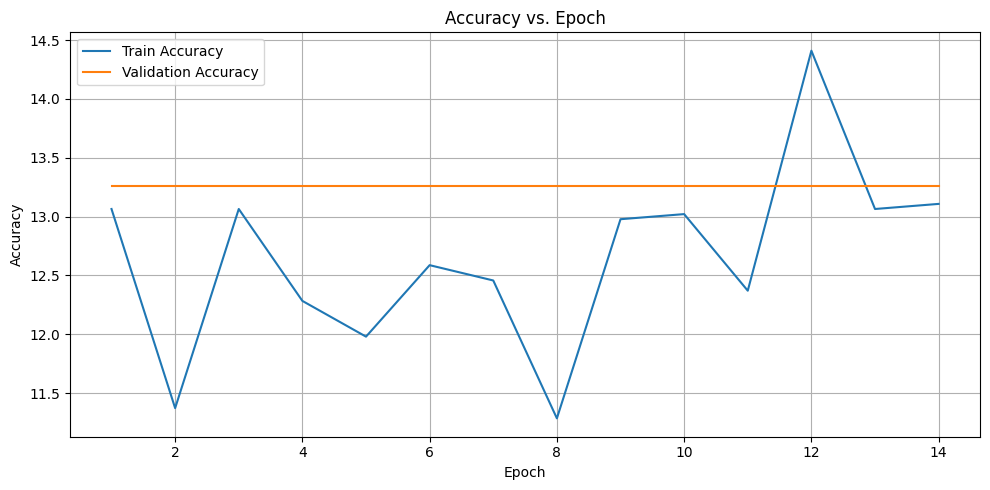

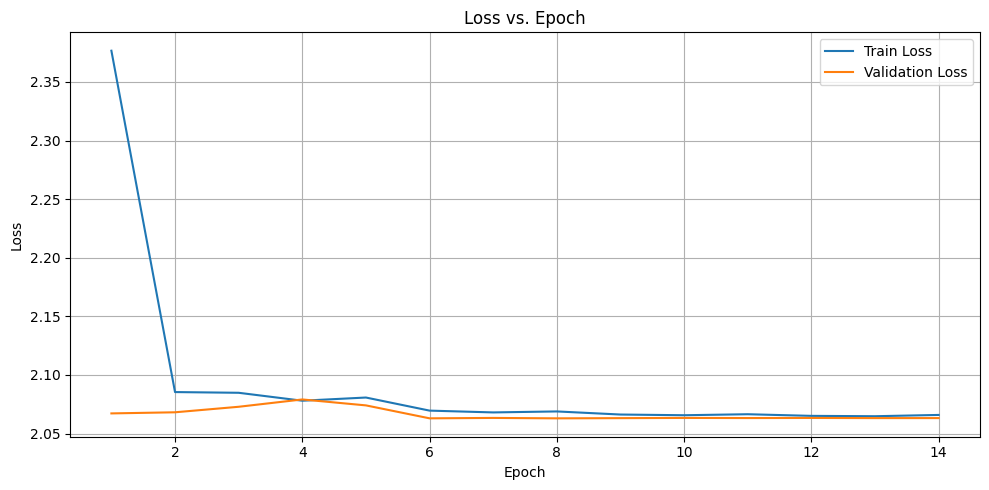

In [39]:
epochs_range = range(1, len(train_accuracies) + 1)
train_accuracies=[x*100 for x in train_accuracies]
val_accuracies=[x*100 for x in val_accuracies]

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_vs_epoch.png")
plt.show()

# Plot Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png")
plt.show()